In [36]:
# reload magics
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
from project_modules.io import load_dataset_to_df
from project_modules.classifcation import classify_MP,getXY, boruta_fs
from project_modules.utils import MPutils
from sklearn.ensemble import RandomForestClassifier
import multiprocessing
from sklearn.model_selection import cross_val_score
import cupy as cp
from datetime import datetime

from tqdm.notebook import tqdm
from copy import deepcopy


from umap import UMAP
import matplotlib.colors as mc

import colorcet as cc
from sklearn.pipeline import Pipeline
# clustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
# from project_modules.utils import get_logger
# logger = get_logger("log-data-combine-split.log")
# # read the parameter file

# from project_modules.utils import read_parameters
# parms = read_parameters("/Users/david/projects/lc-project-data/project.yaml")

pd.options.display.max_columns = None
pd.options.display.max_rows = 50

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
lScorersBinary = [
    "accuracy",
    "balanced_accuracy",
    "roc_auc",
    "f1",
    "recall",
    "sensitivity",
    "specificity",
    "precision",
    # "average_precision",
    "NPV",
    "PPV",
    # "neg_mean_squared_error",
]
lResCol = [
    "Title",
    "cv",
    "param_clf",
    "param_clf__max_depth",
    "param_clf__n_estimators",
    "param_clf__random_state",
    # "param_clf__max_iter",
    "mean_test_accuracy",
    "mean_test_balanced_accuracy",
    "mean_test_roc_auc",
    "mean_test_f1",
    "mean_test_recall",
    "mean_test_sensitivity",
    "mean_test_specificity",
    "mean_test_precision",
    "mean_test_NPV",
    "mean_test_PPV",
]

In [4]:
# lDataNames = ['T81','T85','DT']


lDataNames = [
    "dfcmpltPreLC3",  # LEFT
    "dfcmpltPreLC3_SITE1", # LEFT
    "dfcmpltPreLC3_SITE2", # LEFT
    "dfcmpltPreLC3_SITE3", # LEFT
    "dfcmpltPreLC3_SITE4", # LEFT
    "dfcmpltPreLC3_SITE5",  # LEFT
    "dfcmpltPreLC3_SITE6",  # LEFT
    "dfcmpltPreLC3_SITE7",  # LEFT
]
dataDir = "../Data/DataV3/TTS/"

In [5]:
site_name_dict = {1: "LDN", 2: "MTL", 3: "SAN", 4: "RIO", 5: "LUS", 6: "CA", 7: "NA"}
status_name_dict = {0: "HC", 1: "LC_NEG", 2: "LC_POS"}

In [6]:
selFeatName = 'FS_dfcmpltPreLC3_Boruta_T1000_itrr500_th100_topR5_MD3'
selData = 'dfcmpltPreLC3_SITE4'

df_h = load_dataset_to_df(f"{dataDir}{selData}_Holdout.arrow", verbose=True)

lColDrop = ["__index_level_0__", "LC_STATUS_SITE",'SITE']

df_h.drop(df_h[df_h["LC_STATUS"] == 2].index, inplace=True)  # drop HC

# df_h["LC_STATUS"] = df_h["LC_STATUS"].apply(
#     lambda x: 1 if x == "LC_POS" else 0
# )  # Convert to 0==LCNeg, 1==LCPos

for c in lColDrop:
    if c in df_h.columns:
        df_h.drop(columns=[c], inplace=True)

featDir= selFeatName.replace('FS_','').split('_Boruta')[0]
lColFS = MPutils.getTrueFeatList(f"OUTPUT/MP/05-classifiers/DataV3/{featDir}/{selFeatName}.csv")


## HOLDOUT SET ONLY
x_h, y_h = getXY(df_h)
x_h = x_h[lColFS]

In [7]:
# from the data dictionary
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
}

# assign consistent styles
site_style = {
              1: 'D',
              2: 'o',
              3: 'P',
              4: 'X',
              5: 's',
}

In [8]:
palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')


In [10]:
def make_categorical_colours(df, palette=cc.glasbey_hv):

    # make a list of colours
    colours_dict = {feature: palette[i] for i, feature in enumerate(df.columns)}
    return colours_dict



# sns.barplot(
# data = df,
# x = "Importance",
# y = "Feature",
# orient = 'h',
# legend = False,
# ax = ax,
# hue = "Feature",
# palette = make_categorical_colours(df,cc.glasbey_hv ),
# )

# Process data and run clustering

In [49]:
# globalfeat = 'FS_dfcmpltPreLC3_Boruta_T1000_itrr500_th100_topR5_MD3'
valSelTests = {
    # "dfcmpltPreLC3":[
    #     globalfeat
    # ],
    "dfcmpltPreLC3_SITE1":{
        'featlist':'FS_dfcmpltPreLC3_SITE1_Boruta_T1000_itrr500_th100_topR5_MD5',
        'site':'London',
    },
    "dfcmpltPreLC3_SITE2":{
        'featlist':'FS_dfcmpltPreLC3_SITE2_Boruta_T1000_itrr500_th100_topR5_MD3',
        'site':'Montreal',
    },
    "dfcmpltPreLC3_SITE3":{
        'featlist':'FS_dfcmpltPreLC3_SITE3_Boruta_T1000_itrr500_th100_topR5_MD3',
        'site':'San Diego',
    },
    "dfcmpltPreLC3_SITE4":{
        'featlist':'FS_dfcmpltPreLC3_SITE4_Boruta_T1000_itrr500_th100_topR5_MD3',
        'site':'Rio',
    },
    "dfcmpltPreLC3_SITE5":{
        'featlist': 'FS_dfcmpltPreLC3_SITE5_Boruta_T1000_itrr500_th100_topR5_MD3',
        'site':'Lusaka'
    },
    "dfcmpltPreLC3_SITE6":{
        'featlist':'FS_dfcmpltPreLC3_SITE6_Boruta_T1000_itrr500_th100_topR5_MD3',
        'site':'Canada',
    },
    "dfcmpltPreLC3_SITE7":{
        'featlist':'FS_dfcmpltPreLC3_SITE7_Boruta_T1000_itrr500_th100_topR5_MD3',
        'site':'NorthAmerica',
    },
}
valSelKeys = ['dfcmpltPreLC3_SITE1',
 'dfcmpltPreLC3_SITE2',
 'dfcmpltPreLC3_SITE3',
 'dfcmpltPreLC3_SITE4',
 'dfcmpltPreLC3_SITE5',
 'dfcmpltPreLC3_SITE6',
 'dfcmpltPreLC3_SITE7']

In [62]:
for selData in tqdm(valSelTests.keys(),desc='DataSet Main Outer Loop'):
    
    tmpDict = valSelTests[selData] # get site Dict
    selFeatName = tmpDict['featlist'] #get site feature file
    
    #load df
    df_h = load_dataset_to_df(f"{dataDir}{selData}_Holdout.arrow", verbose=True)
    
    df_h.drop(df_h[df_h["LC_STATUS"] == 2].index, inplace=True)  # drop HC
    
    #drop columns
    lColDrop = ["__index_level_0__", "LC_STATUS_SITE",'SITE']
    for c in lColDrop:
        if c in df_h.columns:
            df_h.drop(columns=[c], inplace=True)

    tmpDict['data'] = df_h #store data
    
    #init saving dir
    tmpDict['savedir'] = MPutils.get_saving_dir(
        f"OUTPUT/MP/05-classifiers/DataV3/{selData}/"
    )

    #get Sel Cols
    tmpDict['featDir']= selFeatName.replace('FS_','').split('_Boruta')[0]
    tmpDict['selCols']= MPutils.getTrueFeatList(f"OUTPUT/MP/05-classifiers/DataV3/{tmpDict['featDir']}/{selFeatName}.csv")
    
    #get x and y
    x_h, y_h = getXY(df_h)
    tmpDict['x_h']=x_h[tmpDict['selCols']]# select Boruta Cols and store
    tmpDict['y_h']=y_h #store labels

    # UMAP
    umap_parms = {
                    'n_components': 2,
                    'spread':       40.0,
                    'random_state': 42,
                }

    # instantiate the pipeline
    pipe = Pipeline([
                    # scale to unit size
                    ('scaler', MinMaxScaler()),
                    ('umap', UMAP(**umap_parms, verbose = False)),
                    ])

    pipeTrans= pipe.fit_transform(tmpDict['x_h']) #run pipeline for dataset
    
    dfTrans = pd.DataFrame(pipeTrans) #convert to dataframe
    dfTrans['LC'] = tmpDict['data']['LC_STATUS'].map({0:'LC Neg',1:'LC Pos'}) #set LC column
    tmpDict['umap'] = dfTrans #store umap dataset
        
    # TSNE
    tsne_parms = {
                    'n_components': 2,
                    'perplexity': 10.0,
                    'random_state': 42,
                }

    # instantiate the pipeline
    pipe = Pipeline([
                    # scale to unit size
                    ('scaler', MinMaxScaler()),
                    ('tsne', TSNE(**tsne_parms, verbose = False)),
                    ])

    pipeTrans= pipe.fit_transform(tmpDict['x_h']) #run pipeline for dataset
    
    dfTrans = pd.DataFrame(pipeTrans) #convert to dataframe
    dfTrans['LC'] = tmpDict['data']['LC_STATUS'].map({0:'LC Neg',1:'LC Pos'}) #set LC column
    tmpDict['tsne'] = dfTrans #store umap dataset

DataSet Main Outer Loop:   0%|          | 0/7 [00:00<?, ?it/s]

/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.p

# UMAP Plot Site Based

/tmp/ipykernel_287251/315109750.py:11: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=tmpDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=0.8, ax=ax[splot], edgecolor='black', linewidth=0.5)
/tmp/ipykernel_287251/315109750.py:11: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=tmpDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=0.8, ax=ax[splot], edgecolor='black', linewidth=0.5)
/tmp/ipykernel_287251/315109750.py:11: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=tmpDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=0.8, ax=ax[splot], edgecolor='black', linewidth=0.5)
/tmp/ipykernel_287251/315109750.py:11: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=tmpDict['umap'

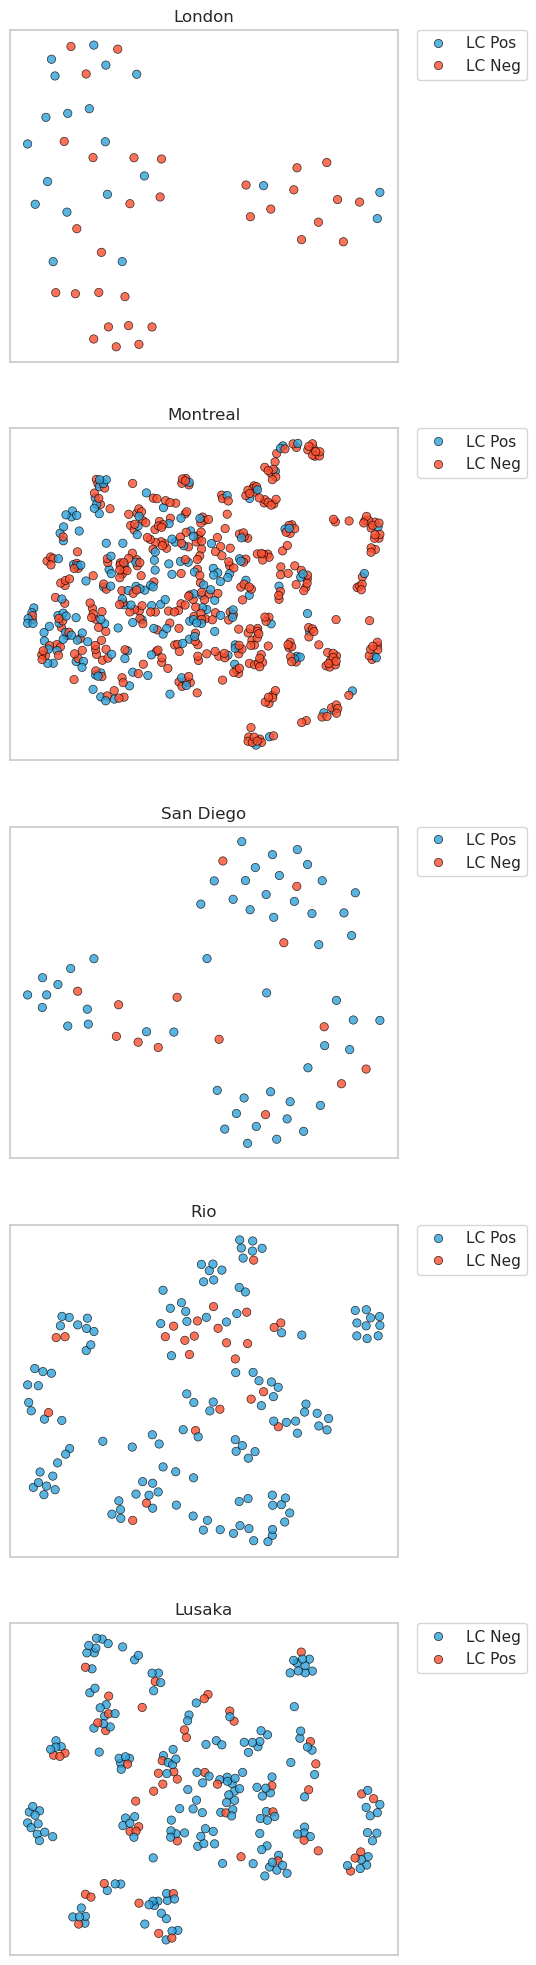

In [63]:
#init subplots
sString = 'A;B;C;D;E'
fig, ax = plt.subplot_mosaic(sString,figsize=(5,25))

#go through sites and plot
for i, splot in enumerate(sString.replace(';','')):
    
    tmpDict = valSelTests[valSelKeys[i]] #get site dictionary

    #plot umap
    sns.scatterplot(data=tmpDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=0.8, ax=ax[splot], edgecolor='black', linewidth=0.5)
    
    #setup plot
    ax[splot].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax[splot].set_xticks([]); ax[splot].set_yticks([])
    ax[splot].set_xlabel(""); ax[splot].set_ylabel("")
    ax[splot].set_title(tmpDict['site'])
    

# TSNE

/tmp/ipykernel_287251/210328732.py:11: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=tmpDict['tsne'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=0.8, ax=ax[splot], edgecolor='black', linewidth=0.5)
/tmp/ipykernel_287251/210328732.py:11: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=tmpDict['tsne'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=0.8, ax=ax[splot], edgecolor='black', linewidth=0.5)
/tmp/ipykernel_287251/210328732.py:11: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=tmpDict['tsne'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=0.8, ax=ax[splot], edgecolor='black', linewidth=0.5)
/tmp/ipykernel_287251/210328732.py:11: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=tmpDict['tsne'

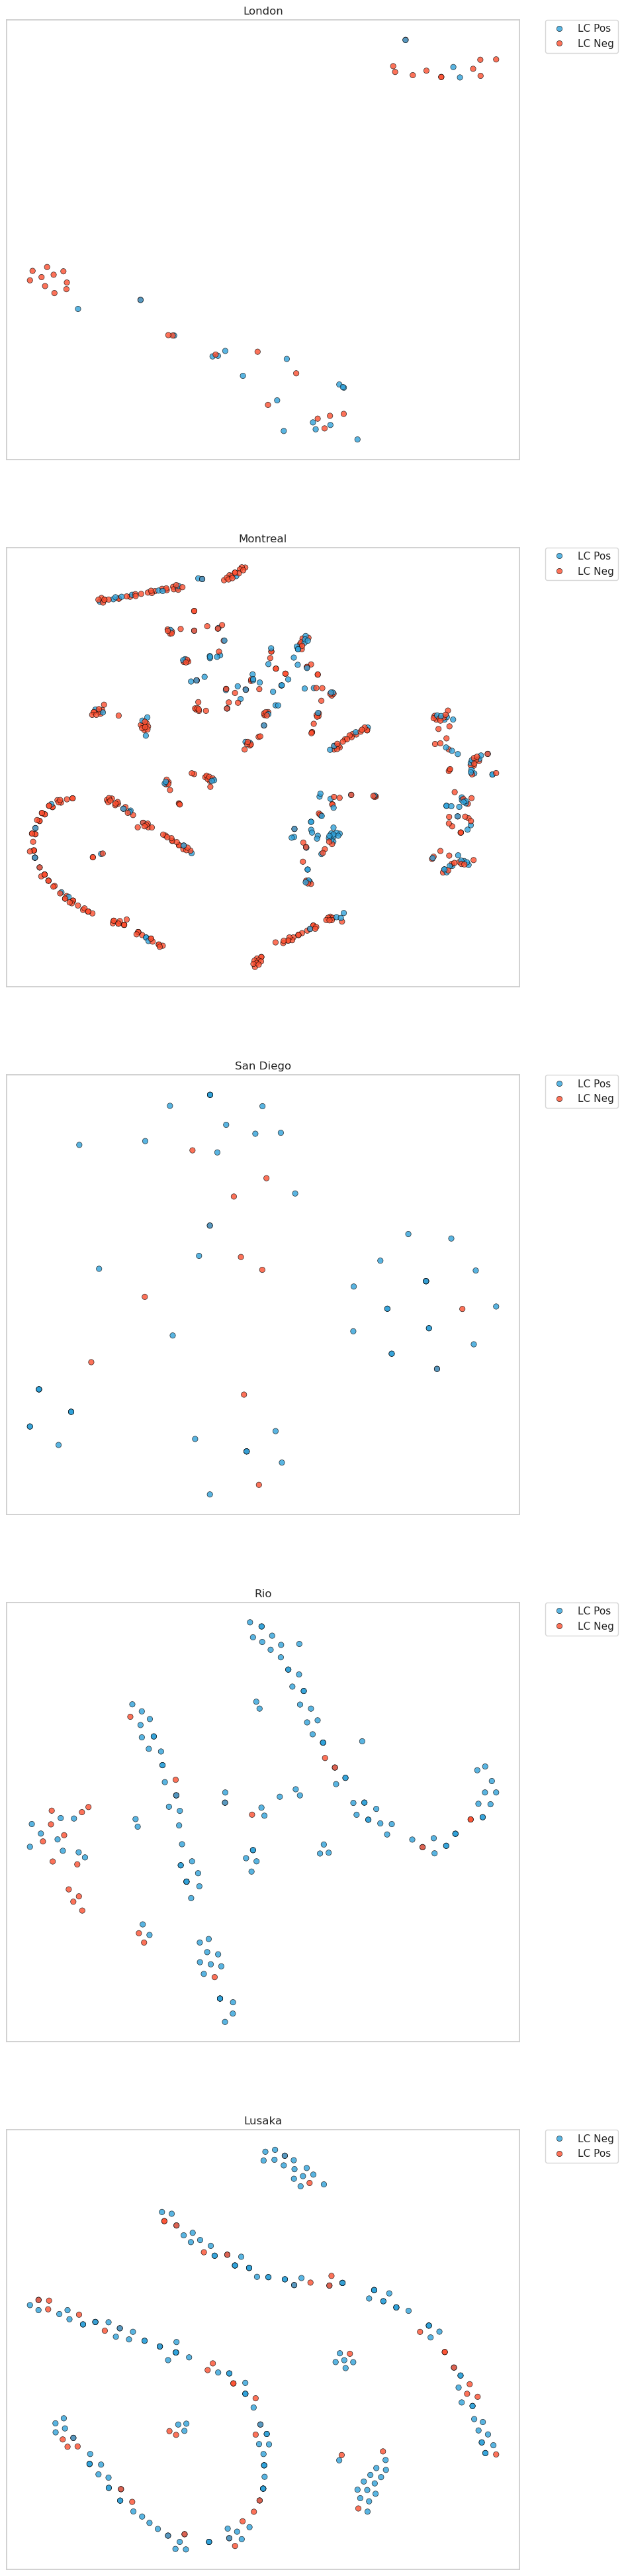

In [53]:
#init subplots
sString = 'A;B;C;D;E'
fig, ax = plt.subplot_mosaic(sString,figsize=(10,50))

#go through sites and plot
for i, splot in enumerate(sString.replace(';','')):
    
    tmpDict = valSelTests[valSelKeys[i]] #get site dictionary

    #plot umap
    sns.scatterplot(data=tmpDict['tsne'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=0.8, ax=ax[splot], edgecolor='black', linewidth=0.5)
    
    #setup plot
    ax[splot].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax[splot].set_xticks([]); ax[splot].set_yticks([])
    ax[splot].set_xlabel(""); ax[splot].set_ylabel("")
    ax[splot].set_title(tmpDict['site'])
    